<a href="https://colab.research.google.com/github/dieko95/AlgoTrading/blob/master/AlgoTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlgoTrading - Machine Learning approach 

This notebook was elaborated for the final project of the course "Algorithmic Trading" taught at Hult International Business School by professor Michael Rolleigh. The goal is to backtest a trading algorithm that recieves the output from a machine learning model as a signal to perform the strategy.

This notebook includes the process from data cleaning until the creation of ML models to use as a signal in a Trading Algorithm. The latter is implemented in ```backtest.py ```


## Using the Notebook to run Machine Learning models -  Section 4



---

### Step 1 

Copy the notebook to your google drive -> /File/Save a Copy in Drive 

### Step 2

In order to run the ML models is necessary to **previously** run the cells from the sections:

* 1.1
* 1.2 
* 1.3.1 
* 1.3.5 

### Step 3

After running these cells, you may begin to run the Machine Learning code at section 4.0



---



> ## Authors

---



The following list integrates the team members that contributed with their expertise in Finance, Trading, Machine Learning and Coding. 


*   Diego Giménez 
* Jorge Betancourt
* Myungsung Kim 
* Piya Thavornwong 
* Xuan Lu 
* Yoon Hee Bae





## 1.0 Load Libraries and Data

https://pypi.org/project/GetOldTweets3/



```
python Exporter.py --query @RedHat --since 2014-01-01 --until 2019-01-15 --maxtweets 5000000
```



### 1.1 Install Libraries

In [1]:
!pip install langdetect
!pip install vaderSentiment
!pip install -U -q PyDrive
!pip install -q xlrd

 

     |████████████████████████████████| 1.0MB 9.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
     |████████████████████████████████| 133kB 9.6MB/s 
     |████████████████████████████████| 993kB 9.9MB/s 


### 1.2 Load Libraries

In [0]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np 
from langdetect import detect
import time
import seaborn as sns

### 1.3 Load Past Data

#### 1.3.1 Google Validation to read Google Drive Files 

In [0]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#### 1.3.2 Load Twitter Past WebScraped Data

In [0]:

link = 'https://drive.google.com/open?id=1NSuc3X37Z2r29mxKt92JFs0krF63aNNM'
fluff, id = link.split('=')

print(id)


1NSuc3X37Z2r29mxKt92JFs0krF63aNNM


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
tweetsDf = pd.read_csv('Filename.csv')

In [0]:
tweetsDf.shape

(51603, 10)

#### 1.3.3 Load Fundamental Past Data

In [0]:
import pandas as pd


file_id = '1P-479AOJBUh1gAcTuxhGtsZHr_17nYV5'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('exported.xlsx')

fundData = pd.read_excel('exported.xlsx')



#### 1.3.4 Load Cleaned and Aggregated Tweets

In [0]:
file_id = '1wtJlq-ebnj-5cimnB6Yl_T2FNYy21Ul4'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('aggDfDay_v0.1.csv')

aggTweetsDay = pd.read_csv('aggDfDay_v0.1.csv')

#### 1.3.5 Load Final Df for ML

In [0]:
file_id = '1XtSm0enUNyogW-xjWctuZLHmEDHwJbqh'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('mlFullDf.csv')

mlDf = pd.read_csv('mlFullDf.csv')

## 2.0 Text Cleaning for Freshly Webscraped tweets 

Don't use this if you downloaded the csv cleaned tweets 

### 2.1 First Cleaning Iteration

In [0]:
# Erasing Short Tweets

start_time = time.time()

tweetsDf.text = tweetsDf.text.apply(lambda x: len(str(x).split()) < 3 and np.nan or x) #If the tweet is less than 3 characters create a NA place Holder 


# Erasing Misc Characters 

tweetsDf.text = tweetsDf.text.replace(r'@\w*', '', regex = True) # Erases all usernames (word preceding @)
tweetsDf.text = tweetsDf.text.replace(r'#\w*', '', regex = True) # Erases hashtags
tweetsDf.text = tweetsDf.text.replace(r'https://.+', '', regex = True) # Erases URLS

print("Middle of program--- %s seconds ---" % (time.time() - start_time))

tweetsDf.text = tweetsDf.text.replace(r'http://.+', '', regex = True) # Erases URLS
tweetsDf.text = tweetsDf.text.replace(r'=>', '', regex = True) # Erases =>
tweetsDf.text = tweetsDf.text.replace(r'[$-/:-?{-~"^_`\[\]]', '', regex = True) #Replace weird characters
tweetsDf.text = tweetsDf.text.apply(lambda x: len(str(x).split()) < 3 and np.nan or x) #If the tweet is less than 3 characters create a NA place Holder 



tweetsDf = tweetsDf.dropna(subset=['text'])


# Erasing Non English Tweets 

print("Before detect --- %s seconds ---" % (time.time() - start_time))


tweetsDf.text = tweetsDf.text.apply(lambda x: detect(str(x)) != 'en' and np.nan or x) # Creates NA place holder for text that is not in english 

tweetsDf = tweetsDf.dropna(subset=['text'])



print("--- %s seconds ---" % (time.time() - start_time))


Middle of program--- 0.23569488525390625 seconds ---
Before detect --- 0.46584033966064453 seconds ---
--- 273.9805519580841 seconds ---


In [0]:
# Tweets that were deleted - 110 for RHT 
print(tweetsDf.describe(), '\n','\n'
     'Tweets Without Info: ', tweetsDf.shape[0] - tweetsDf.text.dropna().shape[0])

tweetsDf = tweetsDf.dropna(subset=['text'])
tweetsDf.shape

           retweets     favorites
count  44804.000000  44804.000000
mean       3.159405      4.744108
std       19.994508     21.891472
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      1.000000
75%        3.000000      5.000000
max     2877.000000   2330.000000 
 
Tweets Without Info:  0


(44804, 10)

### 2.2 Creation of sentiments

![alt text](https://cdn-images-1.medium.com/max/800/1*G8yV2iaqqfaGfmRPRem2Fw.png)

In [0]:
start_time = time.time()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


analyzer = SentimentIntensityAnalyzer()

tweet = []
number_favourites = []
retweets = []
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []
timeStamp = []


for i in range(tweetsDf.shape[0]):
    tweet.append(tweetsDf.iloc[i,4])
    number_favourites.append(tweetsDf.iloc[i,3])
    retweets.append(tweetsDf.iloc[i,2])
    timeStamp.append(tweetsDf.iloc[i,1])
    vs_compound.append(analyzer.polarity_scores(tweetsDf.iloc[i,4])['compound'])
    vs_pos.append(analyzer.polarity_scores(tweetsDf.iloc[i,4])['pos'])
    vs_neu.append(analyzer.polarity_scores(tweetsDf.iloc[i,4])['neu'])
    vs_neg.append(analyzer.polarity_scores(tweetsDf.iloc[i,4])['neg'])
    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 48.82457375526428 seconds ---


#### 2.1.1 Aggregation by count of sentiments  

In [0]:

twitterDf = DataFrame({'Tweet': tweet,
                        'Favourites': number_favourites,
                        'retweets' : retweets,
                        'timeStamp' : timeStamp,
                        'Compound': vs_compound,
                        'Positive': vs_pos,
                        'Neutral': vs_neu,
                        'Negative': vs_neg})
twitterDf = twitterDf[['timeStamp','Tweet', 'Favourites', 'retweets','Compound',
                         'Positive', 'Neutral', 'Negative']]

twitterDf.shape

(44803, 8)

### 2.3 Download Cleaned Tweets

In [0]:
# from google.colab import files

# twitterDf.to_csv('cleanedTwitter_v0.1.csv')
# files.download('cleanedTwitter_v0.1.csv')

### 2.4 Aggregating By Day - Tweets

In [0]:
aggDf = twitterDf.drop(columns = 'Tweet')
aggDf.timeStamp = pd.to_datetime(aggDf.timeStamp) 
aggDf.set_index(aggDf["timeStamp"],inplace=True)
aggDfDay = aggDf.resample('D').sum()

# aggDfDay.Compound.value_counts()

aggDfDay

,Favourites,retweets,Compound,Positive,Neutral,Negative
timeStamp,,,,,,
2013-12-31,1,0,0.5106,0.191,0.809,0.000
2014-01-01,0,0,0.0000,0.000,0.000,0.000
2014-01-02,21,38,1.1823,1.203,3.797,0.000
2014-01-03,16,45,0.9725,0.624,5.233,0.143
2014-01-04,15,48,0.8392,0.628,3.372,0.000
2014-01-05,1,4,0.2732,0.231,2.769,0.000
2014-01-06,3,9,1.4242,0.922,3.016,0.062
2014-01-07,86,375,6.9726,4.778,20.690,0.532
2014-01-08,11,43,3.4217,2.339,10.661,0.000


### 2.5 Download Data

In [0]:
# from google.colab import files

# aggDfDay.to_csv('aggDfDay_v0.1.csv')
# files.download('aggDfDay_v0.1.csv')

### 2.6 Index for tweets loaded from Local System

This tweets were downloaded in section 1.3.4. The index is assigned again when the DF is created from a csv.  



In [0]:
 
print(aggTweetsDay.shape,aggFundDfDay.shape)

aggTweetsDay = aggTweetsDay.iloc[1:1826,:]

print(aggTweetsDay.shape,aggFundDfDay.shape)

NameError: ignored

In [0]:
aggTweetsDay.timeStamp = pd.to_datetime(aggTweetsDay.timeStamp) 
aggTweetsDay.set_index(aggTweetsDay["timeStamp"],inplace=True)

## 3.0 Joining Alternative Data and Fundamental Data

The Alternative data corresponds to the tweets that were webscraped, analyzed, and aggregated by date (section 2). The fundamental data was downloaded separately and loaded in section 1.3.3.

### 3.1 Explore Fundamental Data DF


In [0]:
fundData.head()

,timeStamp,Open,High,Low,Close,Adj Close,Volume,MA50,MA200,Adj Close t,Adj Close t+1,Return,Diluted EPS,EBIT Margin,EBITDA Margin,Revenue % Growth,EBITDA % Growth,EBIT % Growth,NetIncome % Growth,Net Debt to Equity
0,2014-01-02,55.950001,56.000000,55.389999,55.830002,55.830002,1122500,NaN,NaN,55.830002,55.779999,-0.000896,0.22,0.1451,0.1956,0.1713,0.1072,0.0437,0.2361,-0.5785
1,2014-01-03,55.900002,56.240002,55.450001,55.779999,55.779999,1103500,NaN,NaN,55.779999,56.340000,0.010039,0.22,0.1451,0.1956,0.1713,0.1072,0.0437,0.2361,-0.5785
2,2014-01-06,56.180000,56.709999,55.930000,56.340000,56.340000,2028100,NaN,NaN,56.340000,57.419998,0.019169,0.22,0.1451,0.1956,0.1713,0.1072,0.0437,0.2361,-0.5785
3,2014-01-07,56.610001,57.599998,56.400002,57.419998,57.419998,1834100,NaN,NaN,57.419998,56.990002,-0.007489,0.22,0.1451,0.1956,0.1713,0.1072,0.0437,0.2361,-0.5785
4,2014-01-08,57.230000,57.389999,56.750000,56.990002,56.990002,1686600,NaN,NaN,56.990002,57.290001,0.005264,0.22,0.1451,0.1956,0.1713,0.1072,0.0437,0.2361,-0.5785


### 3.2 Aggregate by Day and create dateTime Index 

This is done to ensure that the data is properly aggregated and the DF has the propper index. 

In [0]:
print('Before Agg',aggFundDf.shape)
aggFundDf = fundData
aggFundDf.timeStamp = pd.to_datetime(aggFundDf.timeStamp) 
aggFundDf.set_index(aggFundDf["timeStamp"],inplace=True)
aggFundDfDay = aggFundDf.resample('D').sum()
print('After Agg',aggFundDf.shape)

NameError: ignored

### 3.3  Inner Join tables

In [0]:
finalDf = aggFundDfDay.join(aggTweetsDay,'timeStamp')
finalDf.head()


finalDfNames = [
       'Diluted EPS from Continuing Operations', 'EBIT Margin',
       'EBITDA Margin', 'Revenue % Growth', 'EBITDA % Growth', 'EBIT % Growth',
       'Net Income from Continuing Operations Sequential % Growth',
       'Net Debt to Equity', 'Favourites', 'retweets', 'Compound',
       'Positive', 'Neutral', 'Negative','Return'
]


finalDf = finalDf[finalDfNames]

finalDf.head()

### Download FinalDf

# from google.colab import files

# finalDf.to_csv('mlFullDf.csv')
# files.download('mlFullDf.csv')

NameError: ignored

## 4.0 Machine Learning 

### 4.1 Data Prep



#### 4.1.1 Creating Features and Target

The target corresponds to the next day returns (which were calculated separately in the loaded csv ). The features include fundamental and alternative Data

In [18]:
mlDf = mlDf.dropna()

# Net income % growth is shortened for Net Income from Continuing Operations Sequential % Growth

feature_names = [
       'Diluted EPS', 'EBIT Margin',
       'EBITDA Margin', 'Revenue % Growth', 'EBITDA % Growth', 'EBIT % Growth',
       'NetIncome % Growth',
       'Net Debt to Equity', 'Favourites', 'retweets', 'Compound','timeStamp',
       'Positive', 'Neutral', 'Negative'
]

# Setting the Time Stamp as the Index
mlDf.timeStamp = pd.to_datetime(mlDf.timeStamp) 
mlDf.set_index(mlDf["timeStamp"],inplace=True)

# Changing Name of Column 
# mlDf = mlDf.rename(columns = {'Net Income from Continuing Operations Sequential % Growth':'NetIncome % Growth'})


# Create features and targets
# mlDf Loaded in First Section
features = mlDf[feature_names]
features = features.drop(columns="timeStamp")
targets = mlDf['Return']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['Return'] + feature_names
feat_targ_df = mlDf[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                      Return  Diluted EPS  ...   Neutral  Negative
Return              1.000000     0.043457  ...  0.004254  0.005220
Diluted EPS         0.043457     1.000000  ...  0.314090  0.179761
EBIT Margin         0.030326     0.886864  ...  0.144018  0.059455
EBITDA Margin       0.029090     0.862329  ...  0.124235  0.046035
Revenue % Growth    0.033500     0.925080  ...  0.195040  0.094093
EBITDA % Growth     0.031476     0.787757  ...  0.318801  0.205550
EBIT % Growth       0.029349     0.756347  ...  0.319788  0.205432
NetIncome % Growth  0.009910     0.401226  ...  0.117560  0.068854
Net Debt to Equity -0.033897    -0.863612  ... -0.203379 -0.106857
Favourites          0.002452     0.240223  ...  0.838847  0.794346
retweets            0.001478     0.177373  ...  0.721259  0.696416
Compound            0.001805     0.390663  ...  0.961987  0.839535
Positive            0.004805     0.352096  ...  0.981501  0.899260
Neutral             0.004254     0.314090  ...  1.000000  0.93

#### 4.1.2 Train Test Split

The split is set to have as training set the "oldest" data and the test set the "newest" data. This is due to the fact that the goal is to create a model that predicts future returns. Thus, newest data.

Nonetheless, it is necesary to implement stratified cross validation due to Data Leakage (Prado, 2018)



---



One reason k-fold CV fails in finance is because observations
cannot be assumed to be drawn from an IID process. A second reason for CV’s failure
is that the testing set is used multiple times in the process of developing a model,
leading to multiple testing and selection bias (...) Leakage takes place when the training set contains information that also appears
in the testing set (Prado, 2018).

In [19]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print(features.shape, train_features.shape, test_features.shape)

# train_features = train_features.drop(columns='timeStamp')
# test_features = test_features.drop(columns='timeStamp')

# train_features = train_features.dropna()
# test_features = test_features.dropna()

(1824, 14) (1550, 14) (274, 14)


#### 4.1.3 Correlation Matrix Heatmap

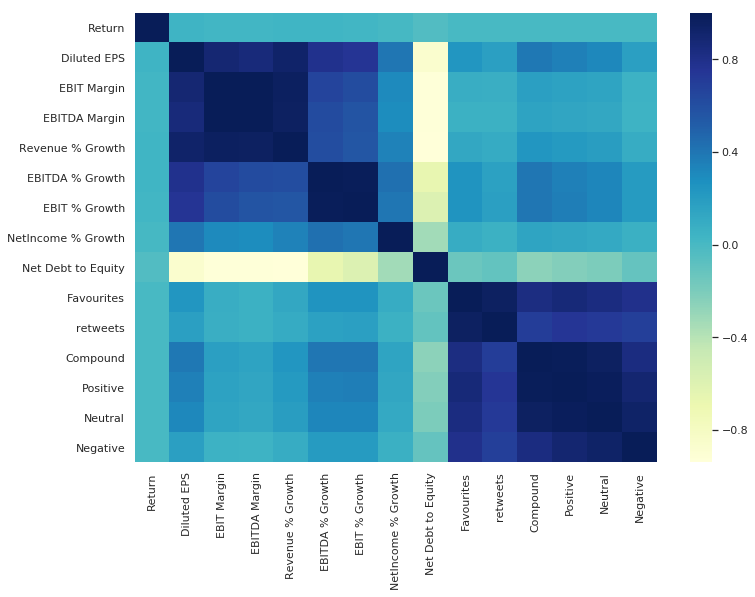

In [20]:
import seaborn as sns 

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(feat_targ_df.corr(), cmap="YlGnBu")

### 4.2 First Generic Model - Decision Tree 

Hugely Overfit! We use the output of this model as the signal in the `Backtesting.Py` script. The reasoning behind this decision is replicating a dangerous situation in algorithmic trading: Implementing an overfit model without being conscious of the plausible dangers.  

In [21]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor(random_state=0)

decFit = decision_tree.fit(train_features,train_targets)

print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features,test_targets))

0.9999786765405798
-0.7474783390027289


#### 4.2.1 Decision Tree with Cross Validation 

We can observe the R Squared scores in each train and test split, in all of the cases the data is overvitted

In [22]:
from sklearn.model_selection import cross_validate, cross_val_score

decision_tree = DecisionTreeRegressor(random_state=0)

scores = cross_validate(decision_tree,features,targets,return_train_score=True, cv=5)
scores  

{'fit_time': array([0.02315593, 0.01267219, 0.01313186, 0.01441097, 0.0187676 ]),
 'score_time': array([0.00146484, 0.00128222, 0.00115538, 0.00118637, 0.00122857]),
 'test_score': array([-2.27199045, -3.25758357, -0.54325437, -1.72530914, -0.21013178]),
 'train_score': array([0.999972  , 0.99997764, 0.99995611, 0.99998701, 0.99997562])}

#### 4.2.2 Visualizing the Decision Tree

In [0]:
# # Visualizing the decision Tree

# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(decFit, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

#### 4.2.3 Decision Tree with GridSearch


In [24]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)
num_leafs = [5, 10, 20, 50, 100]

param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

decision_tree = DecisionTreeRegressor(random_state=0)

gs = GridSearchCV(estimator=decision_tree, param_grid=param_grid, scoring='r2', cv=5)

gs = gs.fit(features, targets)

gs.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 3, 'max_leaf_nodes': 5}

In [25]:
decision_tree = DecisionTreeRegressor(random_state=0, max_depth=3, max_leaf_nodes=5)

decFit = decision_tree.fit(train_features,train_targets)


print('Training Set: ', decision_tree.score(train_features, train_targets))
print('Test Set: ', decision_tree.score(test_features,test_targets))

Training Set:  0.0324927236377307
Test Set:  -0.2626922883901126


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


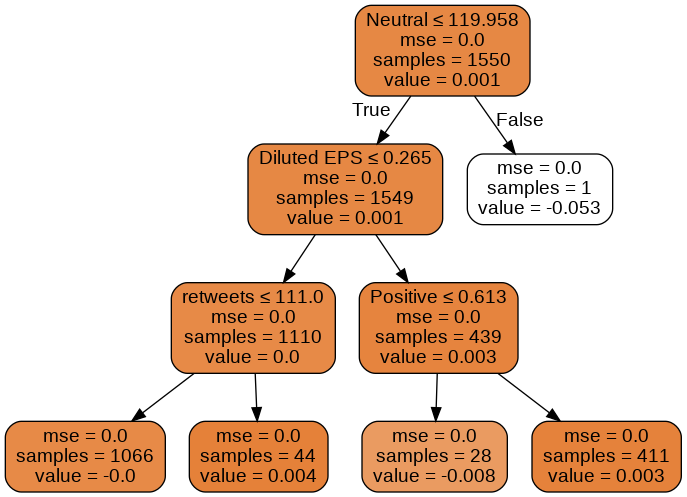

In [26]:
# Visualizing the decision Tree

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(decFit, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = features.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### 4.2.4 Download Decision Tree Model for `Backtesting.py`

In [0]:
# toExp = pd.DataFrame({'timeStamp':mlDf.index, 'predictedReturns':decFit.predict(features)})

In [0]:
# from google.colab import files

# toExp.to_csv('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')
# files.download('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')

In [0]:
# tests = pd.DataFrame({'Original Returns':test_targets, 'predictedReturns':decFit.predict(test_features)})
# tests

### 4.3 Random Forest

#### 4.3.1 Fit Random Forest with default params

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(random_state = 0)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features,test_targets))



0.7875499157518719
-0.2012072203642412


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### 4.3.2 GridSearch Random Forest 

In [28]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)
num_leafs = [5, 10, 20, 50, 100]


param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs,
              }]

gs = GridSearchCV(estimator=rfr, param_grid=param_grid,return_train_score=True, scoring='r2',verbose=1, cv=5)

gs = gs.fit(features, targets)




print('Best Score:{} \n Best Params: {}'.format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:-0.005815546185934584 
 Best Params: {'max_depth': 1, 'max_leaf_nodes': 5}


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   19.0s finished


#### 4.3.3 Cross-Validation for Random Forest

In [29]:
from sklearn.model_selection import cross_validate, cross_val_score


cross_validate(rfr,features,targets,return_train_score=True, cv=5)
  

{'fit_time': array([0.07982111, 0.08213043, 0.07405448, 0.07921147, 0.07833457]),
 'score_time': array([0.00216889, 0.00273895, 0.00208187, 0.0021162 , 0.00193477]),
 'test_score': array([-0.24431601, -0.51402594, -0.11362423, -0.22067487, -0.13105994]),
 'train_score': array([0.80560899, 0.80701658, 0.82439097, 0.8169063 , 0.8023067 ])}

#### 4.3.4 Fit Random Forest with gridsearched parameters 

In [0]:
rfr = RandomForestRegressor(max_depth=1, max_leaf_nodes=5 ,random_state = 0, n_estimators=1000)
rfr = rfr.fit(train_features, train_targets)

In [42]:
cross_validate(rfr,features,targets,return_train_score=True, cv=5)

{'fit_time': array([1.10403848, 1.10741377, 1.08739066, 1.09377813, 1.10147119]),
 'score_time': array([0.03889203, 0.03976917, 0.0457015 , 0.03957367, 0.03891301]),
 'test_score': array([-0.00019332, -0.00126622, -0.00829948, -0.00871218, -0.00879906]),
 'train_score': array([0.00893242, 0.00903727, 0.00979969, 0.00795266, 0.01005103])}

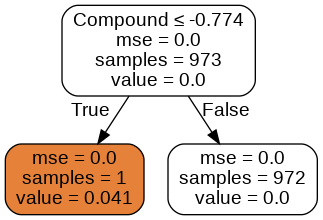

In [43]:
# Visualizing first decision tree of forest


from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(rfr.estimators_[0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = features.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### 4.3.5 Feature Selection with Random Forest

Text(0.5, 0, 'Relative Importance')

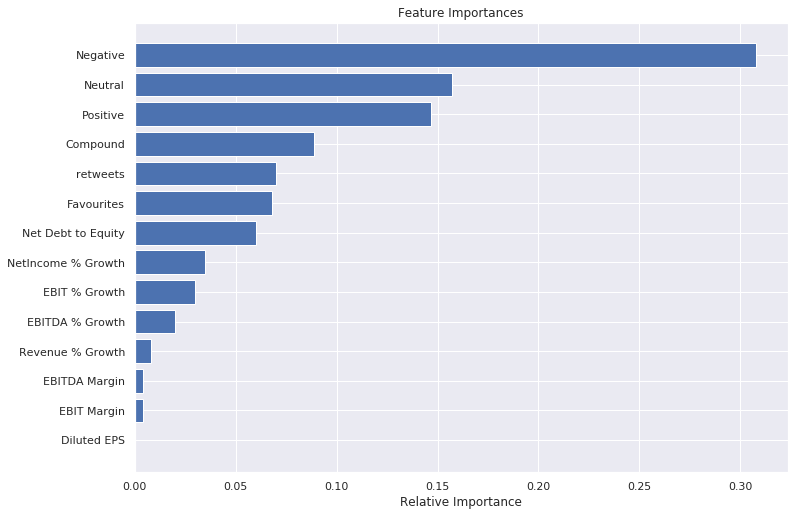

In [0]:
import matplotlib.pyplot as plt

importances = rfr.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')


  # If we want to print each feature importance
# for feature in zip(feature_names, rfr.feature_importances_):
#     print(feature)

### 4.4 Gradient Boosting Regressor

In [0]:
import numpy as np
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls').fit(train_features, train_targets)
# r2_score(test_targets, est.predict(test_features))    
# explained_variance_score(test_targets, est.predict(test_features))
explained_variance_score(train_targets, est.predict(train_features))

0.2452221282521364

#### 4.4.1 Feature Selection Gradient Boosting

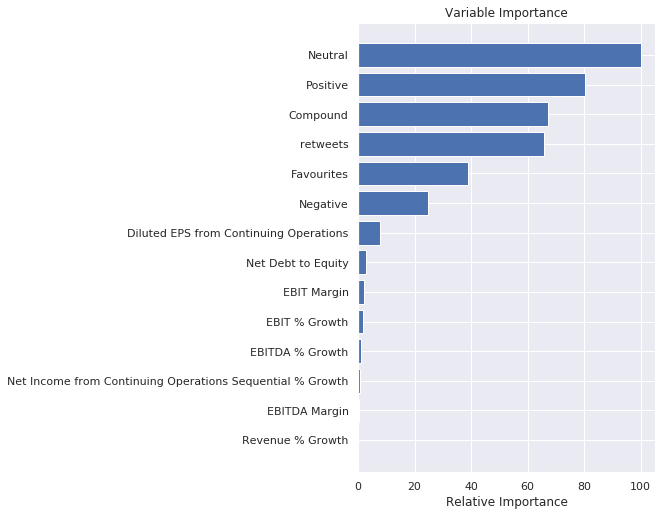

In [0]:
# Plot feature importance
feature_importance = est.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 4.5 Neural Nets

#### 4.5.1 Scale Variables 

In [0]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)


#### 4.5.2 Neural net 1

In [0]:

from keras.models import Sequential
from keras.layers import Dense



from numpy.random import seed
seed(1)

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(40, activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=100)


Epoch 1/100
1550/1550 [==============================] - 0s 291us/step - loss: 0.0030
Epoch 2/100
1550/1550 [==============================] - 0s 56us/step - loss: 3.4140e-04
Epoch 3/100
1550/1550 [==============================] - 0s 53us/step - loss: 2.7138e-04
Epoch 4/100
1550/1550 [==============================] - 0s 50us/step - loss: 2.5956e-04
Epoch 5/100
1550/1550 [==============================] - 0s 47us/step - loss: 2.9560e-04
Epoch 6/100
1550/1550 [==============================] - 0s 51us/step - loss: 2.3935e-04
Epoch 7/100
1550/1550 [==============================] - 0s 61us/step - loss: 2.6790e-04
Epoch 8/100
1550/1550 [==============================] - 0s 55us/step - loss: 2.1798e-04
Epoch 9/100
1550/1550 [==============================] - 0s 46us/step - loss: 2.9699e-04
Epoch 10/100
1550/1550 [==============================] - 0s 55us/step - loss: 3.2076e-04
Epoch 11/100
1550/1550 [==============================] - 0s 53us/step - loss: 2.4812e-04
Epoch 12/100
1550/1550

##### 4.5.2.1 Train and Test Predictions Comparison - Neural Net1 

Training Score 0.09762889767758742
Test Score -0.010446870213559833


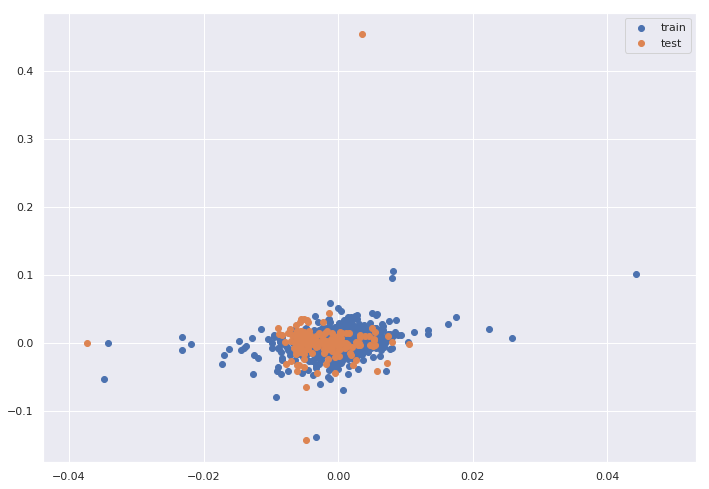

In [0]:
import seaborn as sns 
sns.set()

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print('Training Score {}'.format(r2_score(train_targets, train_preds)))
print('Test Score {}'.format(r2_score(test_targets, test_preds)))

# # Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

##### 4.5.2.2 Plot Loss per Epoch 

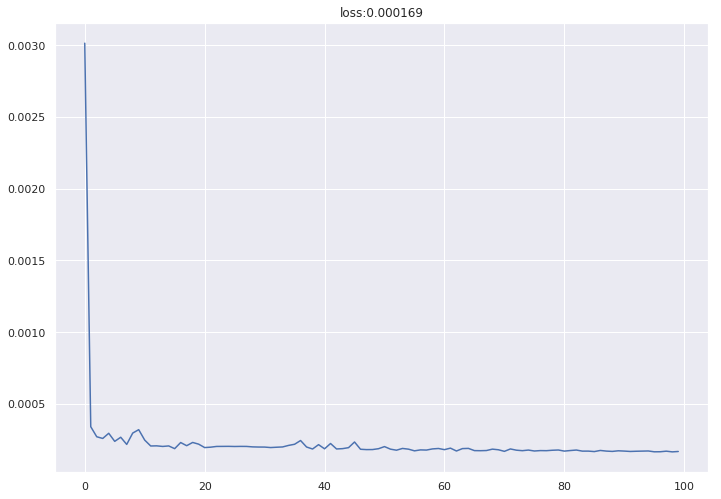

In [0]:
import seaborn as sns 
sns.set()

# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

#### 4.5.3 Neural Net 2 - Custom Loss Function 

In [0]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x7fa3d176c2f0>


##### 4.5.3.1 Plot Loss per Epoch 

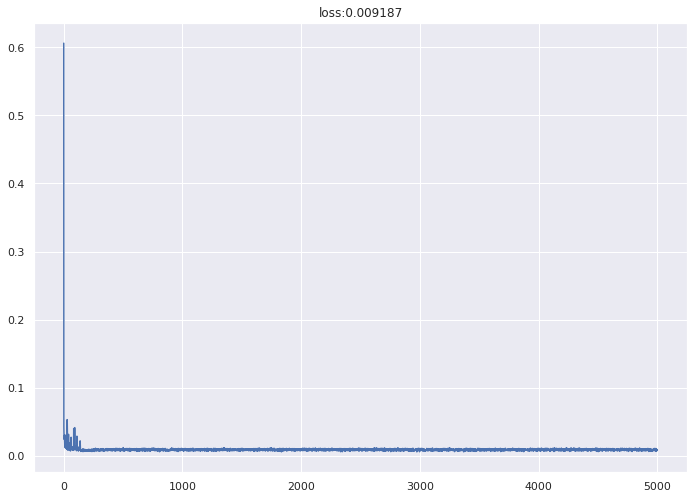

In [0]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=5000, verbose=False)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

##### 4.5.3.2 Plot Model Predictions Train-Test Comparison

-0.002144052129296359
-0.0010737119094283987


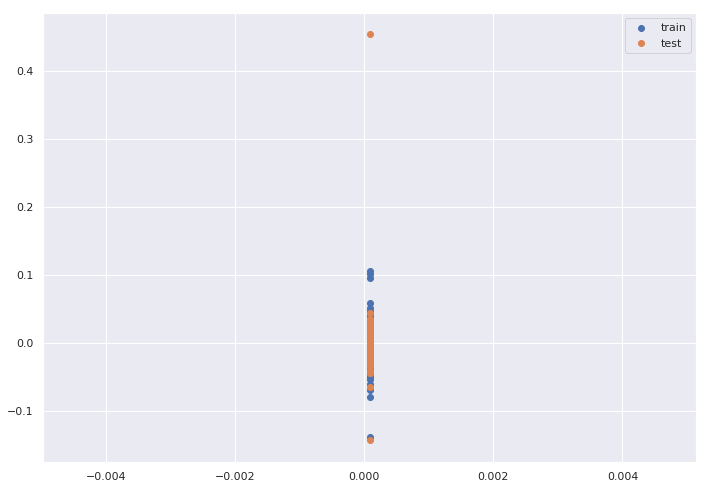

In [0]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()